In [1]:
#!pip install guhdi
#!pip install opencv-python
#!pip uninstall umap-learn
#!pip install umap-learn
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import KernelPCA, FastICA, PCA
from sklearn.manifold import TSNE
#import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler


from cover_complex import *
from scc import *

from gudhi import SimplexTree
from gudhi import CoverComplex

import networkx as nx

# Toy Example

Let's illustrate the mapper algorithm on a simple example.

In [5]:
# Generate data points
np.random.seed(27)
t = np.linspace(0,10,300)
x_circle = np.sin(t)
y_circle = np.cos(t) + np.random.randn(len(t))/10

x_circle_2 = np.sin(t)
y_circle_2 = np.cos(t) -3 + np.random.randn(len(t))/10

x_center = np.random.randn(400)/10
y_center = np.random.randn(400)/3 - 1.5

x = np.concatenate((x_circle, x_circle_2, x_center))
y = np.concatenate((y_circle, y_circle_2, y_center))

X = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)), axis=1)


In [6]:
# Define the filter as the projection on y axis
X_filter = X[:,1]

In [7]:
# Fit mapper

mapper = MapperComplex(input_type="point cloud",
                       resolutions=np.array([7]))
mapper.fit(X, filters=X_filter)

MapperComplex(colors=array([[ 0.00000000e+00],
       [ 3.34385814e-02],
       [ 6.68397634e-02],
       [ 1.00166188e-01],
       [ 1.33380582e-01],
       [ 1.66445797e-01],
       [ 1.99324849e-01],
       [ 2.31980967e-01],
       [ 2.64377625e-01],
       [ 2.96478589e-01],
       [ 3.28247957e-01],
       [ 3.59650195e-01],
       [ 3.90650182e-01],
       [ 4.21213246e-01],
       [ 4.51305203e-01],
       [ 4.80892397e-01],
       [ 5.09941736e-01],
       [ 5.38420731e-01],
       [ 5.66297527e-01]...
       [ 4.75085109e-02],
       [ 1.05207393e-01],
       [-7.21527623e-02],
       [-2.41824374e-03],
       [ 7.25151812e-02],
       [-7.18979491e-04],
       [-4.47452026e-02],
       [-1.19525479e-01],
       [ 6.93919834e-02],
       [-3.84802992e-02],
       [-1.35111680e-01],
       [ 9.41861062e-02],
       [-8.63329050e-03],
       [-1.26048303e-01],
       [ 2.90774830e-02]]),
              filter_bnds=array([[-4.24615034,  1.25635581]]),
              gains=array([0

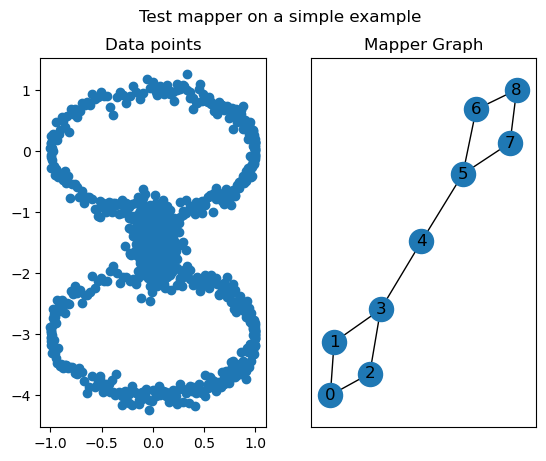

In [5]:
# Plot the resulting graph

G = mapper.get_networkx()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Test mapper on a simple example')
ax1.scatter(x, y)
ax1.set_title("Data points")
nx.draw_networkx(G, ax = ax2)
ax2.set_title("Mapper Graph")
plt.show()

# we obtain the expected graph : 2 linked circles !


# Mapper for Hi-C dataset

Let's try it on our Hi-C dataset :

## Example Run - mean insu

In [9]:
EXP_ID = "02" # to save the computed pairwise distance matrix (it is long to compute)

# Compute pairwise distance matrix
# This class computes the SCC of 2 cells inter-chromosomically

# takes 1min to run for n_cells_sampling = 100

scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
                    n_cells_sampling= 100, # number of cells 
                    h=20, # window size for average smoothing
                    n_slices_max=100 # maximal distance in order to take a contact into account
                    )


# Or, use the alternative class, that first computes the SCC of each 
# chromosomes separately, then computes the average of the SCC of corresponding chromosomes:

#scc_mat = SCCMatrix_chromwise("data/chromosomes.txt",
#                    "data/hi-matrices/",
#                    500, # number of cells 
#                    h=10, # window size for average smoothing
#                    n_slices_max=50 # maximal distance in order to take a contact into account
#                    )

X = scc_mat.compute_pairwise_dist()
#np.save("output/pairwise_distance_" + EXP_ID +".npy", X)


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


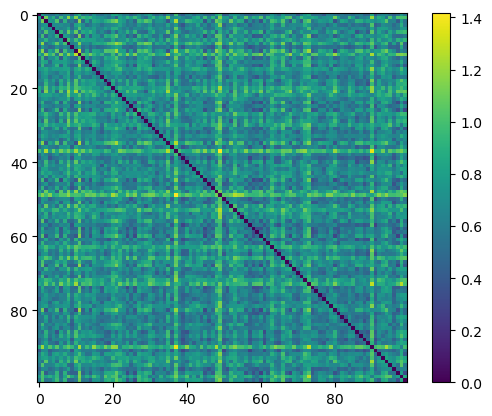

In [10]:
# plot the pairwise distance matrix between cells
plt.imshow(X)
plt.colorbar()
plt.show()

In [11]:
# Get cell features to colorize the graph ; here we use mean_insu, but we have to test with "f near band", "repli score" and "f mitotic band"
cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# save the cells that were drawn for this experiment
# np.save("output/cells_di_" + EXP_ID + ".npy", cells_id)


In [12]:
# compute PCA of this distance matrix ; it will out filter (= lens)
X_scaled = StandardScaler().fit_transform(X)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca = transformer.fit_transform(X_scaled)

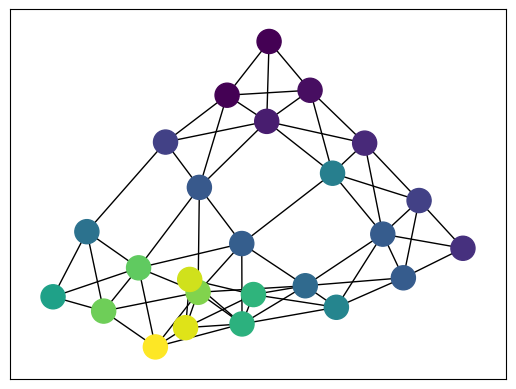

In [14]:
# compute mapper, using 2 first Principal Components as filter
    
RES = 5
GAIN = 0.4
mapper = MapperComplex(input_type="distance matrix", 
                        colors=mean_insu_cells,
                        resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                        clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))
mapper = mapper.fit(X, filters=pca) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
                node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.show()

On voit bien une boucle, et la valeur de la feature mean_insu est bien corrélée avec la progression du cycle !

# Hyper-parameter tuning SCC - 100cells sample

In [107]:
#the higher the number of sampled cell the lower GAIN should be 
RES = 5
GAIN = 0.42

mapper = MapperComplex(input_type="distance matrix", 
                        colors=mean_insu_cells,
                        resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                        clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

In [116]:
#initiate the two studied parameter
list_h = [10, 20, 40]
list_max_slice = [50, 100, 200]

for h in list_h:
    for n_max_slice in list_max_slice:

        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
                    n_cells_sampling= 100, # number of cells 
                    h=h, # window size for average smoothing
                    n_slices_max=n_max_slice # maximal distance in order to take a contact into account
                    )
        
        X = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_scaled = StandardScaler().fit_transform(X)
        transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
        pca = transformer.fit_transform(X_scaled)

        for trial in range(10): 
            mapper = mapper.fit(X, filters=pca) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

            # plot graph
            G = mapper.get_networkx()
            plt.figure()
            nx.draw_networkx(G,
                            node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
            name =  '\output\hp_scc\hp_scc_'+str(h)+'_'+str(n_max_slice)+'_'+str(trial)+'.png'
            plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
            plt.close()          

100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


**count of drawn cycles out of 10** 

The Gain/res hyperparameter should also be dynamically worked on to have better results, but such and iterative process would require too much computing power/ or be too long (knowing that the results must be visually evaluated).

Making the 10 grph on the same sample is also a limiting factor, this induces variance among the different comparisons

<ol>
<li>H:10, n_max_slice:50 -> 0  (many outliers everytime)
<li>H:10, n_max_slice:100 -> 9  (group of 4 outliers everytime)
<li>H:10, n_max_slice:200 -> 0  (The graph is too dense)
<li>h:20, n_max_slice:50 -> 0 (good cycles, but many outliers)
<li>h:20, n_max_slice:100 -> 10 (good cycles everytime, but 7 outliers)
<li>h:20, n_max_slice:200 -> 0 (graph are too connected, it is likely that with a lower RES, results would have been better)
<li>h:40, n_max_slice:50 -> 0 (does not makje a loop and not really sorted, very bad results)
<li>h:40, n_max_slice:100 -> 0 (none of those results are good, too packed and many outliers)
<li>h:40, n_max_slice:200 -> 7 (a cycle is clearly defined, always 5 outliers)
</ol>
Overall those results are strongly limited by the fact that the pairing between the studied variables and the output relies on the graph parameter, that also have to be tuned.

However, it supports that with a h:10, n_max_slice:100 parameter, we can clearly identify the cycles


# Dimensionality reduction tests

## PCA kernel test

In [117]:
#initiate the two studied parameter
ker_list = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']
iter_per_ker =  4

for ker in ker_list:
    for ii in range(iter_per_ker):

        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
                    n_cells_sampling= 100, # number of cells 
                    h=20, # window size for average smoothing
                    n_slices_max=100 # maximal distance in order to take a contact into account
                    )
        
        X = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_scaled = StandardScaler().fit_transform(X)
        transformer = KernelPCA(n_components=2, kernel=ker) # we could try other kernels
        pca = transformer.fit_transform(X_scaled)

        for trial in range(3): 
            mapper = mapper.fit(X, filters=pca) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

            # plot graph
            G = mapper.get_networkx()
            plt.figure()
            nx.draw_networkx(G,
                            node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
            name =  '\output\hp_pca\hp_scc_'+str(ker)+'_'+str(ii)+'_'+str(trial)+'.png'
            plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
            plt.close()          

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


**Results out of 12 trials (4dif samples * 3grpahs)**

<ol>
<li> Cosine: 0, leads to many smaller clusters
<li> Linear: 0, leads to many smaller clusters
<li> Poly: 0, leads to many smaller clsuters
<li> Rbf: 7, a cycle can be seen, heavily reliant on the sample
<li> Sigmoid: 0, small cycles can be seen, but many independant cells
</ol>

## Other dimension reduction techniques

### ICA

In [26]:
RES = 5
GAIN = 0.32
mapper = MapperComplex(input_type="distance matrix", 
                        colors=mean_insu_cells,
                        resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                        clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

In [15]:
runs =  4
for ii in range(runs):

        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
                    n_cells_sampling= 100, # number of cells 
                    h=20, # window size for average smoothing
                    n_slices_max=100 # maximal distance in order to take a contact into account
                    )
        
        X = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_scaled = StandardScaler().fit_transform(X)
        ica = FastICA(n_components=2)
        X_reduced = ica.fit_transform(X)

        for trial in range(4): 
            mapper = mapper.fit(X, filters=X_reduced) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

            # plot graph
            G = mapper.get_networkx()
            plt.figure()
            nx.draw_networkx(G,with_labels = False,
                            node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
            name =  '\output\dim_reduc_result\ICA\ '+str(ii)+'_'+str(trial)+'.png'
            plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
            plt.close()     

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


### T-SNE

In [28]:
RES = 5
GAIN = 0.4
mapper = MapperComplex(input_type="distance matrix", 
                        colors=mean_insu_cells,
                        resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                        clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

In [16]:
runs =  4
for ii in range(runs):

        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
                    n_cells_sampling= 100, # number of cells 
                    h=20, # window size for average smoothing
                    n_slices_max=100 # maximal distance in order to take a contact into account
                    )
        
        X = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_scaled = StandardScaler().fit_transform(X)
        tsne = TSNE(n_components=2)
        X_reduced = tsne.fit_transform(X)

        for trial in range(4): 
            mapper = mapper.fit(X, filters=X_reduced) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

            # plot graph
            G = mapper.get_networkx()
            plt.figure()
            nx.draw_networkx(G,with_labels = False,
                            node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
            name =  "\output\dim_reduc_result\TSNE\ "+str(ii)+'_'+str(trial)+'.png'
            plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
            plt.close()        

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
100%|██████████| 100/100 [01:14<00:00,  1.35it/s]
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
100%|██████████| 100/100 [01:14<00:00,  1.35it/s]
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization

### U-Map

In [38]:
runs =  4
for ii in range(runs):

        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
                    n_cells_sampling= 100, # number of cells 
                    h=20, # window size for average smoothing
                    n_slices_max=100 # maximal distance in order to take a contact into account
                    )
        
        X = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_scaled = StandardScaler().fit_transform(X)
        reducer = umap.UMAP(n_components=2)
        X_reduced = reducer.fit_transform(X)

        for trial in range(4): 
            mapper = mapper.fit(X, filters=X_reduced) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

            # plot graph
            G = mapper.get_networkx()
            plt.figure()
            nx.draw_networkx(G, with_label = False,
                            node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
            name =  r'\output\dim_reduc_result\UMAP\ ' + str(ii) +'_'+str(trial)+'.png'
            plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
            plt.close()        

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


# Hyper-Parameter tuning - Mapper parameters

## Gain & Res based on sample size

### n = 50

In [44]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 50, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_50 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_50_scaled = StandardScaler().fit_transform(X_50)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_50 = transformer.fit_transform(X_50_scaled)

100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


[]

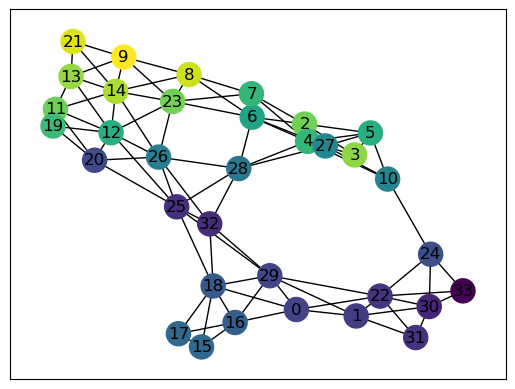

In [78]:
RES = 6
GAIN = 0.48
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_50, filters=pca_50) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

[]

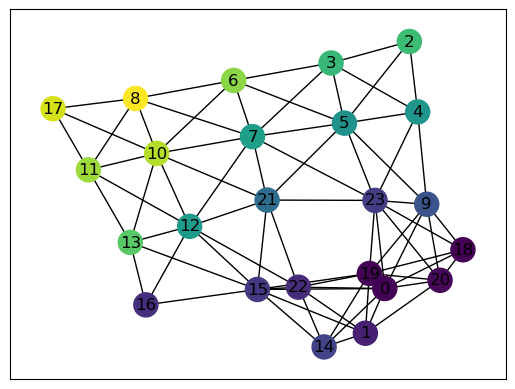

In [93]:
RES = 5
GAIN = 0.51
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_50, filters=pca_50) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

### n = 100 

In [39]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 100, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_100 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_100_scaled = StandardScaler().fit_transform(X_100)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_100 = transformer.fit_transform(X_100_scaled)

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


[]

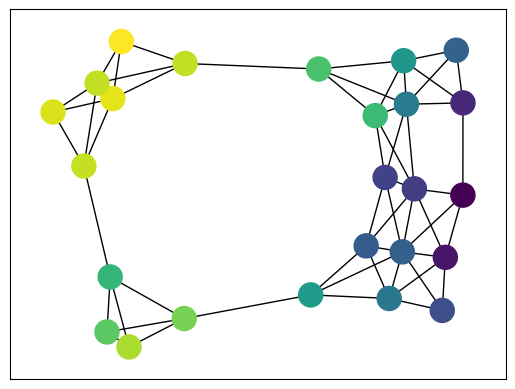

In [49]:
RES = 5
GAIN = 0.37
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_100, filters=pca_100) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

### n = 150

In [48]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 150, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_150 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_150_scaled = StandardScaler().fit_transform(X_150)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_150 = transformer.fit_transform(X_150_scaled)

100%|██████████| 150/150 [02:07<00:00,  1.17it/s]


[]

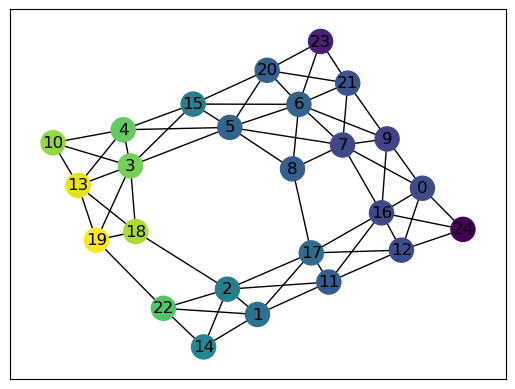

In [40]:
RES = 5
GAIN = 0.35
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_150, filters=pca_150) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

### n = 200

In [49]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 200, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_200 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_200_scaled = StandardScaler().fit_transform(X_200)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_200 = transformer.fit_transform(X_200_scaled)

100%|██████████| 200/200 [03:52<00:00,  1.16s/it]


[]

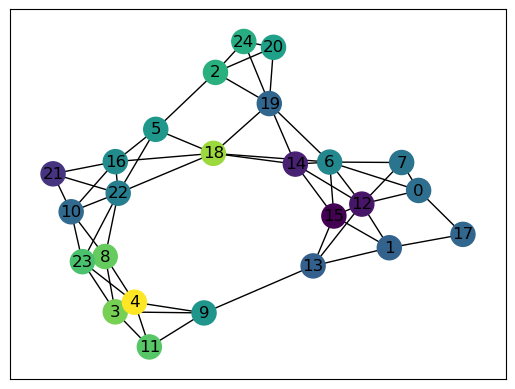

In [139]:
RES = 5
GAIN = 0.25
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_200, filters=pca_200) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G, with_label = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

# Proof based on sampling

The idea is to make N samples, and to see among those N sample wich % result in a cycle that is ordered based on cell status.

Two tresholds have been considered 100 samples of  100 cells, and 70 samples of 150 cells.

Those were plotted using different gain, as seen previsously different gains can result in the appearance, or not, of the searched for cycles.



## 100

In [6]:
n_samples = 100 
for n_sample in range(n_samples):
        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
            n_cells_sampling= 100, # number of cells 
            h=20, # window size for average smoothing
            n_slices_max=100,
            sample_repeat= True,
            seed = i +1 )

        X_100 = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_100_scaled = StandardScaler().fit_transform(X_100)
        transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
        pca_100 = transformer.fit_transform(X_100_scaled)

        for ii in range(3):

                RES = 5
                GAIN = 0.35+ ii *0.02
                mapper = MapperComplex(input_type="distance matrix", 
                                    colors=mean_insu_cells,
                                    resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                                    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

                mapper = mapper.fit(X_100, filters=pca_100) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

                # plot graph            
                G = mapper.get_networkx()
                plt.figure()
                nx.draw_networkx(G,
                    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
                name =  '\output\stat_test\ '+str(n_sample)+'_'+str(int(GAIN*100))+'.png'
                plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
                plt.close()

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


In [51]:
cycles = [2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
16, 17, 19, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32,
33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 49, 53
, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67,
69, 72, 74, 75, 76, 77, 78, 80, 81, 82, 87, 88, 89, 91,
93, 94, 95, 97, 99]

len(cycles)

71

## 150

In [8]:
n_samples = 70 
for n_sample in range(n_samples):
        scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
            n_cells_sampling= 150, # number of cells 
            h=20, # window size for average smoothing
            n_slices_max=150,
            sample_repeat= True,
            seed = i +1 )

        X_150 = scc_mat.compute_pairwise_dist()

        cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
        cell_features.index = cell_features["cell_nm"] # set cell names as index
        mean_insu = cell_features["mean_insu"]

        # cells that where selected :
        cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
        for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
            cells_id[i] = cell.replace(".","_")

        mean_insu_cells = mean_insu.loc[cells_id]

        # compute PCA of this distance matrix ; it will out filter (= lens)
        X_150_scaled = StandardScaler().fit_transform(X_150)
        transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
        pca_150 = transformer.fit_transform(X_150_scaled)

        for ii in range(4):

                RES = 5
                GAIN = 0.29+ ii *0.02
                mapper = MapperComplex(input_type="distance matrix", 
                                    colors=mean_insu_cells,
                                    resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                                    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

                mapper = mapper.fit(X_150, filters=pca_150) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

                # plot graph            
                G = mapper.get_networkx()
                plt.figure()
                nx.draw_networkx(G,
                    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
                name =  '\output\stat_test_150\ '+str(n_sample)+'_'+str(int(GAIN*100))+'.png'
                plt.savefig(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper" + name)      
                plt.close()

100%|██████████| 150/150 [02:59<00:00,  1.20s/it]


In [ ]:
cycle = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 
         18, 20, 23, 24, 25, 26, 28, 29, 30, 33, 34,
         37, 40, 42, 45, 47, 48, 50, 51, 56, 57, 58,
         59, 60, 61, 62, 64, 67, 69]

# Does mean insulation dections is likely to lead to other parameter correct detections

## Mean insulation

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


[]

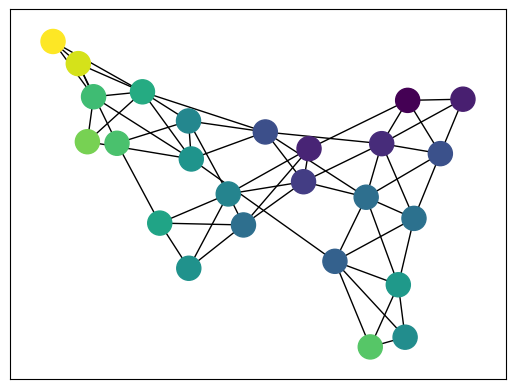

In [73]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 100, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_100 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_100_scaled = StandardScaler().fit_transform(X_100)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_100 = transformer.fit_transform(X_100_scaled)

RES = 5
GAIN = 0.37
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_100, filters=pca_100) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

## f_mitotic_band

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


[]

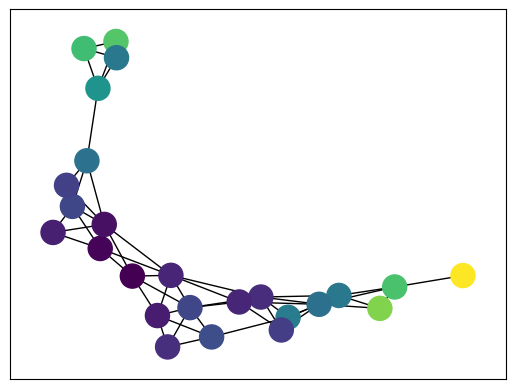

In [74]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 100, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_100 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["f_mitotic_band"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_100_scaled = StandardScaler().fit_transform(X_100)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_100 = transformer.fit_transform(X_100_scaled)

RES = 5
GAIN = 0.37
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_100, filters=pca_100) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

## f_near_band

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


[]

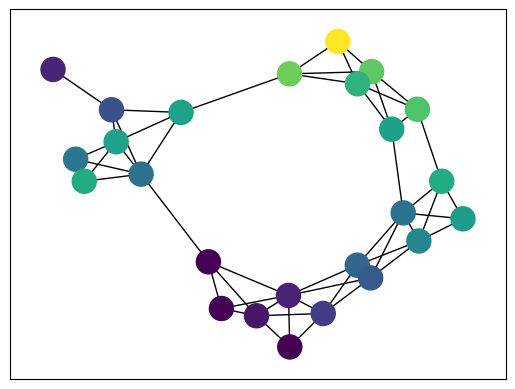

In [75]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 100, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_100 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["f_near_band"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_100_scaled = StandardScaler().fit_transform(X_100)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_100 = transformer.fit_transform(X_100_scaled)

RES = 5
GAIN = 0.37
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_100, filters=pca_100) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

## repli_score

100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


[]

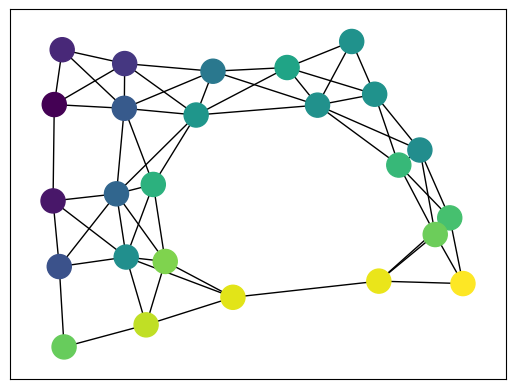

In [2]:
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 100, # number of cells 
    h=20, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )

X_100 = scc_mat.compute_pairwise_dist()

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["repli_score"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# compute PCA of this distance matrix ; it will out filter (= lens)
X_100_scaled = StandardScaler().fit_transform(X_100)
transformer = KernelPCA(n_components=2, kernel='rbf') # we could try other kernels
pca_100 = transformer.fit_transform(X_100_scaled)

RES = 5
GAIN = 0.37
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(X_100, filters=pca_100) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

In [78]:
#get the correlation matrix
cell_features[['mean_insu', 'f_mitotic_band', 'f_near_band', 'repli_score']].corr().to_excel('res.xlsx')

# Test mapper on direct contact map pca

In [2]:
#get the smoothed matrices, increased h, otherwise it crashed
scc_mat = SCCMatrix(hic_matrices_folder=r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data/processed/",
    n_cells_sampling= 100, # number of cells 
    h=80, # window size for average smoothing
    n_slices_max=100 # maximal distance in order to take a contact into account
    )
scc_mat.smooth_all(scc_mat.h)

contact_maps = scc_mat.smooth_matrices

#create vectors for PCA
contact_maps = [x.flatten() for x in contact_maps]

cell_features = pd.read_table(r"C:\Users\oliha\Documents\GitHub\HIC_Mapper\data\data_features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]


In [3]:
contact_maps_scaled = StandardScaler().fit_transform(contact_maps)
pca = PCA(n_components=2)
pca_2 = pca.fit_transform(contact_maps_scaled)

MemoryError: Unable to allocate 20.4 GiB for an array with shape (100, 27394756) and data type float64

[]

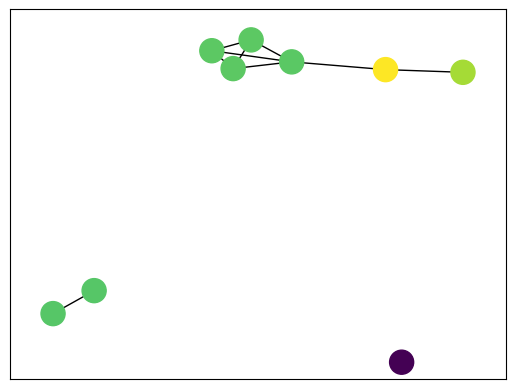

In [ ]:
RES = 5
GAIN = 0.37
mapper = MapperComplex(input_type="distance matrix", 
                       colors=mean_insu_cells,
                       resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                       clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))

mapper = mapper.fit(contact_maps_scaled, filters=pca_2) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,with_labels = False,
    node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.plot()

# TO DO next

On a trouvé un set de paramètre qui permet de mettre en évidence le cycle cellulaire ! (cf exemple ci-dessus)

Suite : Etude des hyperparamètres (pas forcément tous !) :
 
SCC :    
- `h`, la taille de la fenêtre pour l'average smoothing
- `n_slices_max` : la distance max entre 2 DNA bins pour prendre en compte le contact. A voir si on peut calculer le SCC en ne mettant pas ce seuil, mais je crois que ça sera super long.
- Est-ce qu'on le calcule chromosome par chromosome (`SCCMatrix_chromwise()`), ou est-ce qu'on utilise l'ensemble de la contact map avec tous les crhomosomes d'un coup (`SCCMatrix()`) ?

Mapper : 
- Le type de Kernel dans la PCA
- Le nombre de PCs qu'on prend en compte comme filter
- `RES` : le paramètre de résolution
- `GAIN` : le paramètre d'overlap
- L'algo de clustering utilisé, et notamment le seuil $\delta$